In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Basic Libraries 📚

import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [3]:
# Basic Modules & Useful Installations

import warnings
warnings.simplefilter(action='ignore')

In [4]:
# Geo Libraries 📚

import geopandas as gpd
from geopy.distance import geodesic
from geopy.distance import great_circle

In [5]:
# Machine Learning Libraries

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [6]:
# Find Nearby

def find_nearby_coworks(campsite, coworks, max_distance_km):
    nearby_coworks = []
    for _, cowork in coworks.iterrows():
        dist = great_circle((campsite.latitude, campsite.longitude), (cowork.latitude, cowork.longitude)).kilometers
        if dist <= max_distance_km:
            nearby_coworks.append(cowork)
    return nearby_coworks

In [7]:
# Construct reading relative path

relative_path = "my-jobcation-path/02_data_cleaning_phase/01_Preprocessing & Clean/coworkings_chars.csv"
relative_path2 = "my-jobcation-path/02_data_cleaning_phase/01_Preprocessing & Clean/campsites_chars.csv"

# Change directory
os.chdir('C:\\Users\\Oscar\\Documents\\00_Ironhack\\P3_Final\\') #Change for your own directory

# Check directory
current_directory = os.getcwd()
print("Current working directory is:", current_directory)

Current working directory is: C:\Users\Oscar\Documents\00_Ironhack\P3_Final


In [8]:
# Construct absolute paths

coworkings_path = os.path.join(current_directory, relative_path)
campsites_path = os.path.join(current_directory, relative_path2)


In [9]:
# Coworkings reading

if os.path.exists(coworkings_path):
    try:
        # Try to read the CSV file
        data = pd.read_csv(coworkings_path)
        print("The file has been loaded successfully.")
        # Now you can work with the 'data' DataFrame
    except Exception as e:
        print("An error occurred while reading the file:", e)
else:
    print("The file does not exist at the specified path:", coworkings_path)

The file has been loaded successfully.


In [10]:
# Campsites reading

if os.path.exists(campsites_path):
    try:
        # Try to read the CSV file
        data2 = pd.read_csv(campsites_path)
        print("The file has been loaded successfully.")
        # Now you can work with the 'data' DataFrame
    except Exception as e:
        print("An error occurred while reading the file:", e)
else:
    print("The file does not exist at the specified path:", campsites_path)

The file has been loaded successfully.


In [11]:
# Dataframe Creation

dfco = data.copy()
dfca = data2.copy()


## PREPROCESSING for CLUSTERING

- DISTANCE PROBLEM

In the process of information handling through the API, some distances were miscalculated due to the formula for geodesic distances. We analyzed which small part of the dataset is affected and removed these outliers. Regardless of the unsupervised model we're going to use, these data points compromise the consistency of the project and would lead to odd results.

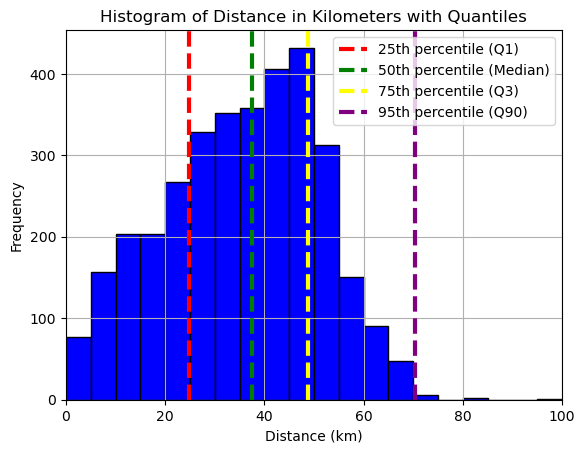

The maximal distance in km is 11603.14830674014 more over the 95th percentile is only 70.37163137640921



In [14]:

# Look for strange distances. Example:
strange_distance = dfca["distance_km"].max()

# Calculate quantiles
q25 = dfca["distance_km"].quantile(0.25)
q50 = dfca["distance_km"].quantile(0.50)  # This is the median
q75 = dfca["distance_km"].quantile(0.75)
q95 = dfca["distance_km"].quantile(0.95)  # Calculating 95th percentile

# Create the histogram
plt.hist(dfca["distance_km"], bins=20, color='blue', edgecolor='black', range=(0, 100))  # Limiting data to 0-100 km

# Add vertical lines for each quantile
plt.axvline(q25, color='red', linestyle='dashed', linewidth=3, label='25th percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=3, label='50th percentile (Median)')
plt.axvline(q75, color='yellow', linestyle='dashed', linewidth=3, label='75th percentile (Q3)')
plt.axvline(q95, color='purple', linestyle='dashed', linewidth=3, label='95th percentile (Q90)')  # Marking the 95th percentile

# Labels & Title
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Histogram of Distance in Kilometers with Quantiles')
plt.grid(True)

# Adjust the x-axis to show up to 100 km
plt.xlim(0, 100)

# Add a legend to make it clear what the lines represent
plt.legend()

plt.show()

print(f'The maximal distance in km is {strange_distance} more over the 95th percentile is only {q95}\n')

In [15]:
# Filtering

dfca = dfca[dfca['distance_km'] <= q95]

In [16]:
# Encoding categoricals. We are going to use manual encoding because we need it for the model after.

type = {
    'City': 0,
    'Town': 1,
    'Village': 2,
}


luxury = {
    'Campsite': 0,
    'Glamping': 1,
    'Camper': 2
}

# Other Features = Beach 1, No beach 0
# Wild 1 (If campsite >60km City, town > 25km, and village >15km)
# Now let's do the mapping

dfca['type'] = dfca['type'].map(type)
dfca['luxury'] = dfca['luxury'].map(luxury)


In [17]:
encoding_column = ["type", "luxury", "beach", "wild", "rating", "distance_km", "longitude", "latitude"] 

df_campsites = dfca[encoding_column]

In [18]:
encoding_column = ["rating","distance_km", "longitude", "latitude"] 

df_cowork = dfco[encoding_column]

## DBSCAN MODEL

In [20]:
# Fix the targeting

Xca = df_campsites


## TEST EUCLIDEAN METRIC

Euclidean Distance : It is the most commonly used metric in DBSCAN. It calculates the straight-line distance between two points in Euclidean space.

In [23]:
# Sample parameter grid to explore

eps_values = [10,15,20,25,30,35,40,45,50]  # Example values (After first tests, we see interesant add values before 50)
min_samples_values = [5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] # After first tests, we see interesant add values between 5-10)


for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize and fit DBSCAN with the current parameter set
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        dbscan.fit(Xca)
        
        # Compute the silhouette score if more than one cluster excluding noise
        if len(np.unique(dbscan.labels_)) > 1:
            score = silhouette_score(Xca, dbscan.labels_)
            db_index = davies_bouldin_score(Xca, dbscan.labels_)
            num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
            print( f'EPS: {eps}, Min_Samples: {min_samples}, Silhouette Score: {score}, Number of Clusters: {num_clusters}, Davies-Bouldin Index: {db_index}')
            


EPS: 10, Min_Samples: 5, Silhouette Score: 0.3441189350907618, Number of Clusters: 8, Davies-Bouldin Index: 0.75849007335007
EPS: 10, Min_Samples: 6, Silhouette Score: 0.3424491445184929, Number of Clusters: 8, Davies-Bouldin Index: 0.912116499906434
EPS: 10, Min_Samples: 7, Silhouette Score: 0.34226781877675755, Number of Clusters: 8, Davies-Bouldin Index: 0.9036205045338295
EPS: 10, Min_Samples: 8, Silhouette Score: 0.37044141299055255, Number of Clusters: 6, Davies-Bouldin Index: 1.1896445289910258
EPS: 10, Min_Samples: 9, Silhouette Score: 0.4679960421479931, Number of Clusters: 5, Davies-Bouldin Index: 1.545519643654222
EPS: 10, Min_Samples: 10, Silhouette Score: 0.46670256162817825, Number of Clusters: 5, Davies-Bouldin Index: 1.5009183025010635
EPS: 10, Min_Samples: 11, Silhouette Score: 0.6493955176506616, Number of Clusters: 3, Davies-Bouldin Index: 1.4222083388271254
EPS: 10, Min_Samples: 12, Silhouette Score: 0.6557416874129068, Number of Clusters: 2, Davies-Bouldin Index: 1

Optimal results as our understanding:

- High value of Siluette (% of sample into clusters)
- Maximize number of clusters
- Minimal posible value of Davies-Bouldin Index (Means more distance between clusters and less distance between points into the cluster)

Options:

EPS: 30, Min_Samples: 9, Silhouette Score: 0.7131012596848337, Number of Clusters: 5, Davies-Bouldin Index: 0.45635034976281585






## TEST MANHATAN METRIC

Manhattan Distance (manhattan): Also known as city block distance or taxicab distance, it calculates the distance between two points by summing the absolute differences of their Cartesian coordinates.

In [27]:
# Sample parameter grid to explore

eps_values = [25,30,35,40,41,42,43,44,45,46,47,48,49,50]  # Example values (After first tests, we see interesant add values between 40-55)
min_samples_values = [5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] # After first tests, we see interesant add values between 5-10)


for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize and fit DBSCAN with the current parameter set
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='manhattan')
        dbscan.fit(Xca)
        
        # Compute the silhouette score if more than one cluster excluding noise
        if len(np.unique(dbscan.labels_)) > 1:
            score = silhouette_score(Xca, dbscan.labels_)
            db_index = davies_bouldin_score(Xca, dbscan.labels_)
            num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
            print( f'EPS: {eps}, Min_Samples: {min_samples}, Silhouette Score: {score}, Number of Clusters: {num_clusters}, Davies-Bouldin Index: {db_index}')
            


EPS: 25, Min_Samples: 5, Silhouette Score: 0.4023815052422666, Number of Clusters: 7, Davies-Bouldin Index: 0.6107983852125412
EPS: 25, Min_Samples: 6, Silhouette Score: 0.4023815052422666, Number of Clusters: 7, Davies-Bouldin Index: 0.6107983852125412
EPS: 25, Min_Samples: 7, Silhouette Score: 0.4023815052422666, Number of Clusters: 7, Davies-Bouldin Index: 0.6107983852125412
EPS: 25, Min_Samples: 8, Silhouette Score: 0.4023815052422666, Number of Clusters: 7, Davies-Bouldin Index: 0.6107983852125412
EPS: 25, Min_Samples: 9, Silhouette Score: 0.4023815052422666, Number of Clusters: 7, Davies-Bouldin Index: 0.6107983852125412
EPS: 25, Min_Samples: 10, Silhouette Score: 0.4023815052422666, Number of Clusters: 7, Davies-Bouldin Index: 0.6107983852125412
EPS: 25, Min_Samples: 11, Silhouette Score: 0.40262756265583177, Number of Clusters: 6, Davies-Bouldin Index: 0.7076744781778709
EPS: 25, Min_Samples: 12, Silhouette Score: 0.40262756265583177, Number of Clusters: 6, Davies-Bouldin Index

Options:

EPS: 35, Min_Samples: 11, Silhouette Score: 0.7146312390053665, Number of Clusters: 5, Davies-Bouldin Index: 0.5613690282903611


## TEST CHERISEV METRIC

Chebyshev Distance (chebyshev): It calculates the maximum absolute difference between the coordinates of the two points. It is useful when you want to measure the distance between two points in a chessboard-like grid.

In [31]:
# Sample parameter grid to explore

eps_values = [20,21,22,23,24,25,30,35,40,45]  # Example values (After first tests, we see interesant add values between 20 and 25)
min_samples_values = [5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] # After first tests, we see interesant add values between 5-10)


for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize and fit DBSCAN with the current parameter set
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='chebyshev')
        dbscan.fit(Xca)
        
        # Compute the silhouette score if more than one cluster excluding noise
        if len(np.unique(dbscan.labels_)) > 1:
            score = silhouette_score(Xca, dbscan.labels_)
            db_index = davies_bouldin_score(Xca, dbscan.labels_)
            num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
            print( f'EPS: {eps}, Min_Samples: {min_samples}, Silhouette Score: {score}, Number of Clusters: {num_clusters}, Davies-Bouldin Index: {db_index}')
            


EPS: 20, Min_Samples: 5, Silhouette Score: 0.4689041749512047, Number of Clusters: 6, Davies-Bouldin Index: 0.7084415187264234
EPS: 20, Min_Samples: 6, Silhouette Score: 0.4689041749512047, Number of Clusters: 6, Davies-Bouldin Index: 0.7084415187264234
EPS: 20, Min_Samples: 7, Silhouette Score: 0.4689041749512047, Number of Clusters: 6, Davies-Bouldin Index: 0.7084415187264234
EPS: 20, Min_Samples: 8, Silhouette Score: 0.4689041749512047, Number of Clusters: 6, Davies-Bouldin Index: 0.7084415187264234
EPS: 20, Min_Samples: 9, Silhouette Score: 0.4689041749512047, Number of Clusters: 6, Davies-Bouldin Index: 0.7084415187264234
EPS: 20, Min_Samples: 10, Silhouette Score: 0.4668950618985482, Number of Clusters: 6, Davies-Bouldin Index: 0.9088604707673805
EPS: 20, Min_Samples: 11, Silhouette Score: 0.4658808029765386, Number of Clusters: 5, Davies-Bouldin Index: 0.8661874461134222
EPS: 20, Min_Samples: 12, Silhouette Score: 0.4658808029765386, Number of Clusters: 5, Davies-Bouldin Index: 

OPTIONS

EPS: 25, Min_Samples: 9, Silhouette Score: 0.7131012596848337, Number of Clusters: 5, Davies-Bouldin Index: 0.45635034976281585


## FINAL CHOICE


Thinking in future feeding, less number de EPS es better for avoid grow the Davies-Bouldin Index, and good for the same reason, so a middle value of EPS.  5 clusters give several options and we admit the error Davies-Bouldin Index, because the data is not balanced.

- EUCLIDEAN

EPS: 30, Min_Samples: 9, Silhouette Score: 0.7131012596848337, Number of Clusters: 5, Davies-Bouldin Index: 0.45635034976281585

In [35]:
# Initialize and fit DBSCAN for campsites
dbscan_campsites = DBSCAN(eps=30, min_samples=9, metric='euclidean').fit(Xca)

# Assign cluster labels
df_campsites['cluster'] = dbscan_campsites.labels_



In [36]:
df_campsites['cluster'].value_counts()

cluster
 0    3329
 4      19
 3      17
 2      14
 1      10
-1       1
Name: count, dtype: int64

- MANHATTAN

EPS: 40, Min_Samples: 11, Silhouette Score: 0.7146312390053665, Number of Clusters: 5, Davies-Bouldin Index: 0.5613690282903611

In [38]:
# Initialize and fit DBSCAN for campsites
dbscan_campsites = DBSCAN(eps=40, min_samples=11, metric='manhattan').fit(Xca)

# Assign cluster labels
df_campsites['cluster'] = dbscan_campsites.labels_



In [39]:
df_campsites['cluster'].value_counts()

cluster
0    3329
4      19
3      17
2      14
1      11
Name: count, dtype: int64

- CHERISEV

EPS: 22, Min_Samples: 5, Silhouette Score: 0.713195169234198, Number of Clusters: 5, Davies-Bouldin Index: 0.4556333684942048

EPS: 22, Min_Samples: 11, Silhouette Score: 0.7147244893988302, Number of Clusters: 4, Davies-Bouldin Index: 0.5603656623502666

EPS: 25, Min_Samples: 9, Silhouette Score: 0.7131012596848337, Number of Clusters: 5, Davies-Bouldin Index: 0.45635034976281585

In [41]:
dbscan_campsites = DBSCAN(eps=22, min_samples=5, metric='chebyshev').fit(Xca)

# Assign cluster labels
df_campsites['cluster'] = dbscan_campsites.labels_

In [42]:
df_campsites['cluster'].value_counts()

cluster
 0    3329
 4      19
 3      17
 2      14
 1      10
-1       1
Name: count, dtype: int64

In [43]:
dbscan_campsites = DBSCAN(eps=22, min_samples=11, metric='chebyshev').fit(Xca)

# Assign cluster labels
df_campsites['cluster'] = dbscan_campsites.labels_

In [44]:
df_campsites['cluster'].value_counts()

cluster
 0    3329
 3      19
 2      17
 1      14
-1      11
Name: count, dtype: int64

In [45]:
dbscan_campsites = DBSCAN(eps=25, min_samples=9, metric='chebyshev').fit(Xca)

# Assign cluster labels
df_campsites['cluster'] = dbscan_campsites.labels_

In [46]:
df_campsites['cluster'].value_counts()

cluster
 0    3329
 4      19
 3      17
 2      14
 1      10
-1       1
Name: count, dtype: int64

## FINAL MODEL

In [48]:
# Initialize and fit DBSCAN for campsites with results EPS: 30, Min_Samples: 9


dbscan_optimal_campsites = DBSCAN(eps=30, min_samples=9, metric='euclidean').fit(Xca)

# Assign cluster labels
df_campsites['cluster'] = dbscan_optimal_campsites.labels_


In [49]:
for cluster_id in np.unique(dbscan_optimal_campsites.labels_):
    if cluster_id == -1:
        continue  # Exclude noise
    cluster_members = df_campsites[df_campsites['cluster'] == cluster_id]
    print(f"Cluster ID: {cluster_id}")
    
    # Example: Find the average distance and ratings, and count characteristics
    avg_distance = cluster_members['distance_km'].mean()
    avg_rating = cluster_members['rating'].mean()
    wild_count = cluster_members['wild'].sum()
    beach_count = cluster_members['beach'].sum()
    type_count = cluster_members['type'].sum()
    luxury_count = cluster_members['luxury'].sum()
    
    print(f"Average Distance: {avg_distance}, Average Rating: {avg_rating}")
    print(f"Wild: {wild_count}, Beach: {beach_count}")
    print(f"City Type: {type}, Beach: {luxury}")
    
    # Further analysis based on 'type' or other factors here
    print(cluster_members, "\n")

Cluster ID: 0
Average Distance: 35.22891323921838, Average Rating: 4.121778311805348
Wild: 2026, Beach: 1033
City Type: {'City': 0, 'Town': 1, 'Village': 2}, Beach: {'Campsite': 0, 'Glamping': 1, 'Camper': 2}
      type  luxury  beach  wild  rating  distance_km  longitude   latitude  \
0        0       0      0     0     3.9     9.458117  -3.603361  40.453734   
1        1       0      0     0     3.9    20.181317  -3.603361  40.453734   
2        1       0      0     0     3.9    24.875383  -3.603361  40.453734   
3        1       0      0     0     3.9    10.851165  -3.603361  40.453734   
4        1       0      0     0     3.9    28.066198  -3.603361  40.453734   
...    ...     ...    ...   ...     ...          ...        ...        ...   
3564     2       0      0     1     4.4    22.713277  -0.206368  43.129771   
3565     2       0      0     1     4.5    47.411886  -0.915795  43.142601   
3566     2       0      0     1     4.5    32.475489  -0.068011  43.104360   
3567     2 

In [100]:
# Example usage for the first campsite
campsite = df_campsites.iloc[18]
coworks = df_cowork
nearby_coworks = find_nearby_coworks(campsite, df_cowork, 15)  # finding coworks within 15 km

In [96]:
# Max and Min distance that you need for find a coworking:

distances = [entry['distance_km'] for entry in nearby_coworks]

# Encontrar el máximo
max_distance = max(distances)
# Encontrar el mínimo
min_distance = min(distances)

In [53]:
# Assuming you add results to your dataframe or a separate list

df_campsites['nearby_coworks_count'] = df_campsites.apply(lambda x: len(find_nearby_coworks(x, df_cowork, 15)), axis=1)

# Recommend campsites with at least one coworking space nearby

recommended_campsites = df_campsites[df_campsites['nearby_coworks_count'] > 0]

In [54]:
import folium

# Create a map centered at an average location
map_center = [df_campsites['latitude'].mean(), df_campsites['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Add points to the map
for _, row in df_campsites.iterrows():
    if row['cluster'] != -1:  # Excluding noise points
        folium.Marker(location=[row['latitude'], row['longitude']],
                      popup=f'Cluster: {row["cluster"]}',
                      icon=folium.Icon(color='blue' if row['cluster'] == 0 else 'red')).add_to(m)

# To display the map in a Jupyter Notebook
m